In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gwpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


1. Importando bibliotecas


In [ ]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame
import yfinance as yf
import math
import matplotlib.pyplot as plt
import random

# Definindo funções

Formula da precificação de opções via Black & Scholes
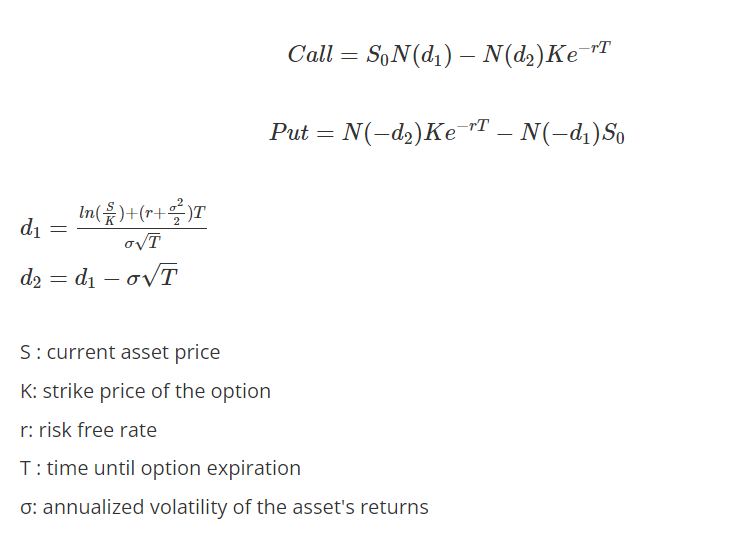


Função de precificação B&S

In [ ]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

In [ ]:
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def bs_put(S,K,T,r,sigma):
    return K * exp(-r * T) - S + bs_call(S,K,T,r,sigma)

In [ ]:
def catch_data(code, start_date, end_date):
    # get data on this ticker
    tickerData = yf.Ticker(code)

    # get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

    return tickerDf

def cdi(start_date, end_date):
  """
  Acopla um vetor chamado "CDI" que contém os retornos do CDI em um dataframe
  """
  url_cdi='http://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados?formato=json'
  df_cdi = pd.read_json(url_cdi)
  df_cdi['data'] = pd.to_datetime(df_cdi['data'], dayfirst=True)
  df_cdi.set_index('data', inplace=True)
  df_cdi = df_cdi[(end_date >= df_cdi.index)]
  df_cdi = df_cdi[(start_date <= df_cdi.index)]
  df_cdi['valor'] = df_cdi['valor']/100
  return df_cdi

# Construindo base

In [ ]:
today = pd.Timestamp(date.today())
number_of_trading_days = 252
bd = pd.tseries.offsets.BusinessDay(n = number_of_trading_days)

base = catch_data("BOVA11.SA",today - bd ,today)
#base_cdi = cdi(today - bd ,today)
#base_cdi.rename(columns = {'valor':'cdi'},inplace = True)

#setando vencimento da opção
vencimento = '2023-07-21'


In [ ]:
base



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-07-07 00:00:00-03:00,96.620003,97.910004,96.580002,97.379997,8341836,0.0,0.0
2022-07-08 00:00:00-03:00,97.519997,98.000000,96.389999,96.879997,6332439,0.0,0.0
2022-07-11 00:00:00-03:00,95.360001,95.760002,94.349998,94.800003,7295507,0.0,0.0
2022-07-12 00:00:00-03:00,94.269997,95.290001,93.830002,94.900002,8193143,0.0,0.0
2022-07-13 00:00:00-03:00,94.199997,95.449997,93.949997,94.510002,5761578,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-19 00:00:00-03:00,114.699997,116.250000,114.699997,116.129997,5422980,0.0,0.0
2023-06-20 00:00:00-03:00,115.510002,115.940002,114.680000,115.820000,5857464,0.0,0.0
2023-06-21 00:00:00-03:00,115.779999,116.779999,115.559998,116.269997,4391740,0.0,0.0


Construindo calendário



In [ ]:
InitialDateList = pd.date_range(datetime.today(), periods=50).tolist()
adjust = []
for i in InitialDateList:
  a= i.strftime('%y-%m-%d')
  #adjust.append(a)
  adjust.append(datetime.strptime(a,'%y-%m-%d'))

#pegando apenas os finais de semana
datelist = []
for i in adjust:
  weekno = i.weekday()
  if weekno<5:
    datelist.append(i)



#construindo df
df = pd.DataFrame()

df['date'] = datelist
df = df[df['date']<= vencimento]


# Executando simulações

Streaming output truncated to the last 5000 lines.
<ipython-input-21-3821c0472347>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj['premiumG'][0] = 0.85
<ipython-input-21-3821c0472347>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj['delta'][0] = -0.2381
<ipython-input-21-3821c0472347>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj['premium'][i] =  bs_put(df_proj['price'][i],112,cdi,dif,std_dev)
<ipython-

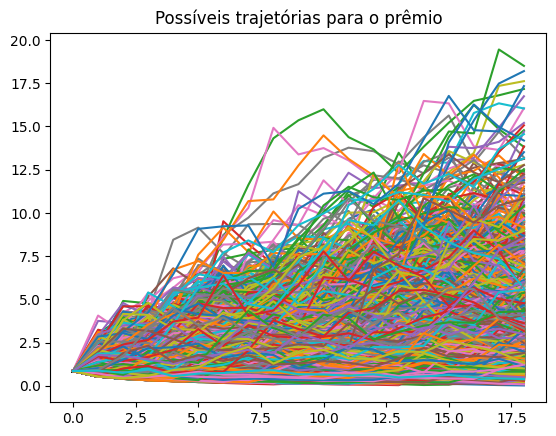

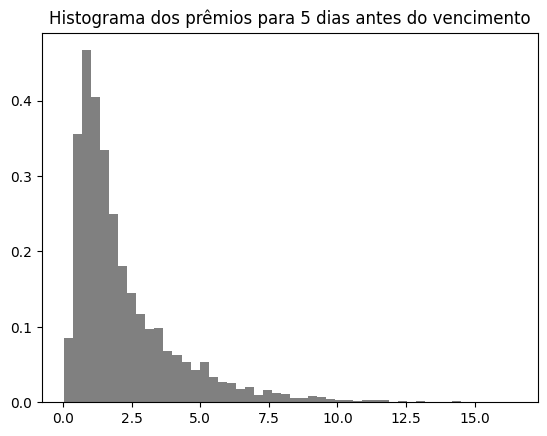

In [ ]:

#Definindo número de projeções
number_of_trials = 5000

#vetores de preço e prêmios
closing_prices = []
closing_premiums = []

for i in range(number_of_trials):
    ###projetando preços do ativo baseando-se na distribuição normal

    #desvio padrão da série de retornos
    std_dev = base['Close'].pct_change().std() *math.sqrt(len(df))
    #cálculo da distribuição
    daily_return_percentages = np.random.normal(0, std_dev/math.sqrt(len(df)),len(df))+1

    #série de preços inicia com o último preço disponível
    price_series = [base['Close'][-1]]

    for j in daily_return_percentages:
        #extrapolando preço para o próximo período
        price_series.append(price_series[-1] * j)

    #Populando vetor de fechamentos
    closing_prices.append(price_series[-1])

    #Fazendo os calculos do Black&Scholes

    df_proj = pd.DataFrame()
    today = today.strftime('%y-%m-%d')
    today = datetime.strptime(today,'%y-%m-%d')


    df_proj['date'] = datelist
    df_proj = df_proj[df_proj['date']<vencimento]  #projeção até o vencimento da opção
    df_proj['price'] = price_series[:-2]
    df_proj['premium'] = ''

    #definindo cdi diário
    cdi_atual = 0.1365
    cdi =((1+cdi_atual)**(1/252)) - 1

    df_proj['delta'] = ''
    df_proj['gamma'] = ''
    df_proj['theta'] = ''
    df_proj['premiumG'] = ''

    #setando gregas a partir dos últimos valores disponíveis, conferir: https://opcoes.net.br/opcoes/bovespa/BOVA11
    df_proj['premiumG'][0] = 0.85
    df_proj['delta'][0] = -0.2381
    df_proj['gamma'] =  0.0486
    df_proj['theta']=  -0.0338
    vega = 10.033



    for i in df_proj.index:
      dif = len(df_proj) - i

      #cálculo do premio por black&Scholes tradicional
      df_proj['premium'][i] =  bs_put(df_proj['price'][i],112,cdi,dif,std_dev)

      #Cálculo do prêmio a partir das gregas
      if i >0:
        df_proj['delta'][i] = df_proj['delta'][i-1] + ((df_proj['price'][i] - df_proj['price'][i-1]) * df_proj['gamma'][i])
        df_proj['premiumG'][i] = df_proj['premiumG'][i-1] + df_proj['theta'][i] + (df_proj['price'][i] - df_proj['price'][i-1])*df_proj['delta'][i]

    #vetor de prêmios a partir do cálculo B&S
    #closing_premiums.append(df_proj['premium'][df_proj.index[-1]])

    #vetor de prêmios a partir das gregas

    days = 5 #dias antes do vencimento
    closing_premiums.append(df_proj['premiumG'][df_proj.index[-days]])

    #plot all random walks
    #plt.plot(price_series)
    plt.plot(df_proj['premiumG'])

plt.title('Possíveis trajetórias para o prêmio')
plt.show()


#plot histogram
#plt.hist(closing_prices,bins=40) #preços

plt.title(f'Histograma dos prêmios para {days} dias antes do vencimento')
plt.hist(closing_premiums,bins =50,density = True, color= 'gray')

plt.show()

In [ ]:
#Prêmio esperado para x dias antes do vencimento

mean_end_price = round(np.mean(closing_premiums),2)
print("Expected price: ", str(mean_end_price))

Expected price:  2.2


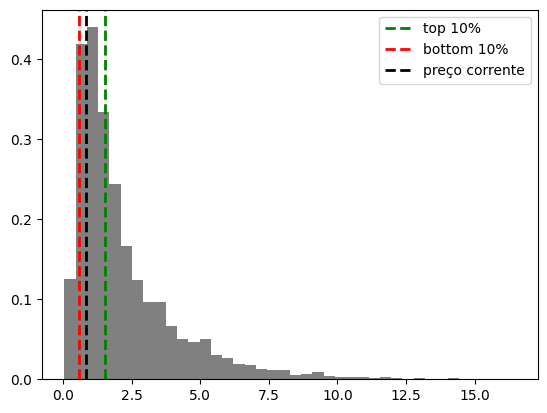

In [ ]:
#Distribuição em percentis

#10% melhores resultados
top_ten = np.percentile(closing_premiums,50)

#10% piores resultados
bottom_ten = np.percentile(closing_premiums,10);

#histograma
plt.hist(closing_premiums,bins=40,density = True,color = 'gray')
#top 10% line
plt.axvline(top_ten,color='g',linestyle='dashed',linewidth=2,label = 'top 10%')

#bottom 10% line
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2,label ='bottom 10%' )

#append with current price
plt.axvline(df_proj['premiumG'][0],color='black', linestyle='dashed',linewidth=2,label = 'preço corrente')

plt.legend(loc='upper right')
plt.show()


# Modelo de precificação para uma projeção


In [ ]:
%%capture
#calculate randomized return percentages following our normal distribution
#and using the mean / std dev we calculated above
std_dev = base['Close'].pct_change().std() *math.sqrt(len(df))
daily_return_percentages = np.random.normal(-0.00005, std_dev/math.sqrt(len(df)),len(df))+1
try:
  del(price_series)
except:
  pass

price_series = [base['Close'][-1]]
for j in daily_return_percentages:
    #extrapolate price out for next year
    price_series.append(price_series[-1] * j)

#append closing prices in last day of window for histogram
closing_prices.append(price_series[-1])

#Fazendo os calculos do Black&Scholes

df_proj = pd.DataFrame()
today = today.strftime('%y-%m-%d')
today = datetime.strptime(today,'%y-%m-%d')


df_proj['date'] = datelist
df_proj = df_proj[df_proj['date']<vencimento]
df_proj['price'] = price_series[:-2]
df_proj['premium'] = ''
cdi =((1+0.1365)**(1/252)) - 1
df_proj['delta'] = ''
df_proj['gamma'] = ''
df_proj['theta'] = ''
df_proj['premiumG'] = ''

df_proj['premiumG'][0] = 0.85
df_proj['delta'][0] = -0.2381
df_proj['gamma'] =  0.0486
df_proj['theta']=  -0.0338
vega = 10.033


for i in df_proj.index:
  dif = len(df_proj) - i
  df_proj['premium'][i] =  bs_put(df_proj['price'][i],112,cdi,dif,std_dev)
  if i >0:
    df_proj['delta'][i] = df_proj['delta'][i-1] + ((df_proj['price'][i] - df_proj['price'][i-1]) * df_proj['gamma'][i])
    df_proj['premiumG'][i] = df_proj['premiumG'][i-1] + df_proj['theta'][i] + (df_proj['price'][i] - df_proj['price'][i-1])*df_proj['delta'][i]

#df_proj['premium'] = bs_put(df_proj['0'],112,0.1365,t,std_dev)


In [ ]:
df_proj

,date,price,premium,delta,gamma,theta,premiumG
0,2023-06-26,115.309998,0.0,-0.2381,0.0486,-0.0338,0.85
1,2023-06-27,117.189422,0.0,-0.14676,0.0486,-0.0338,0.540376
2,2023-06-28,119.042635,0.0,-0.056694,0.0486,-0.0338,0.40151
3,2023-06-29,118.821924,0.0,-0.06742,0.0486,-0.0338,0.38259
4,2023-06-30,119.711637,0.0,-0.02418,0.0486,-0.0338,0.327277
5,2023-07-03,121.416677,0.0,0.058685,0.0486,-0.0338,0.393537
6,2023-07-04,123.615995,0.0,0.165571,0.0486,-0.0338,0.723881
7,2023-07-05,125.781917,0.0,0.270835,0.0486,-0.0338,1.276689
8,2023-07-06,125.772539,0.0,0.27038,0.0486,-0.0338,1.240353
9,2023-07-07,126.797034,0.0,0.32017,0.0486,-0.0338,1.534566


In [ ]:
bottom_ten = np.percentile([1,2,3,4,5,6,7,8,9,10],90)
bottom_ten

9.1